# **VANCOUVER CRIME ANALYSIS PROJECT**

        GROUP 21

        NICOLE LINK
        TIRTH JOSHI
        ZAIN NOFAL



## Summary

In this project, we aim to predict what type of crime occurred in Vancouver based on when and where it happened. We use a dataset from the Vancouver Police Department with over 530,000 crime records from 2003-2017, covering 11 different crime types including theft, break-ins, and vehicle collisions.

We tested three machine learning models: K-Nearest Neighbors, Support Vector Machines, and Logistic Regression. After tuning, all three models performed similarly, achieving around 62-64% accuracy. While this isn't perfect, it shows that time and location do provide some useful information for predicting crime types, though there is clearly room for improvement, possibly with additional features.

## Introduction

### Background

Crime prediction is an important tool for police departments trying to figure out where to focus their resources. Vancouver, like most big cities, has many different types of crime happening at different times and places. If we can predict what kind of crime is likely to happen based on patterns in the data, it could help with planning patrols and prevention efforts.

### Research Question

**Can we predict the type of crime based on when and where it happens?**

We're comparing three different classification algorithms (K-NN, SVM, and Logistic Regression) to see if this is possible, and which model works best for this problem.

### Dataset

We're using the Vancouver Crime Dataset from Kaggle, which originally came from the Vancouver Police Department. It has **530,652 crime records** from **2003 to 2017**, split into **11 crime types**. The most common is "Theft from Vehicle" (over 172,000 cases) and the rarest is "Homicide" (220 cases).

Each record includes:
- **Time info:** year, month, day, hour, minute
- **Location info:** neighborhood, street block, coordinates

There's some missing data - about 10% of records don't have time information and 11% are missing neighborhood data. We filled in missing times with the most common values and labeled missing neighborhoods as "Unknown."

**LOADING IN THE DATA**

In [1]:
import kagglehub
import pandas as pd
import os
import pandera as pa
import json
import logging

# Download latest version
path = kagglehub.dataset_download("wosaku/crime-in-vancouver")

print("Path to dataset files:", path)

Path to dataset files: /Users/zainnofal/.cache/kagglehub/datasets/wosaku/crime-in-vancouver/versions/2


In [2]:
# Data validation: Checking correct data file format
# read data in, and throw error if there is an issue with the format

try:
    df = pd.read_csv(os.path.join(path, "crime.csv"))
except Exception as e:
    raise ValueError(f"File format issue: {e}")
df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
3,Other Theft,2003,4,20,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
4,Other Theft,2003,4,12,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763


# Data Validation

In [3]:
#Code adapted from DSCI 522 lecture notes

# Configure logging
logging.basicConfig(
    filename="validation_errors.log",
    filemode="w",
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
)

#Valid crime types
crime_types=[
    'Other Theft', 
    'Break and Enter Residential/Other', 
    'Mischief',
    'Break and Enter Commercial', 
    'Offence Against a Person',
    'Theft from Vehicle',
    'Vehicle Collision or Pedestrian Struck (with Injury)',
    'Vehicle Collision or Pedestrian Struck (with Fatality)',
    'Theft of Vehicle', 
    'Homicide', 
    'Theft of Bicycle'
]

# Manually check for and remove privacy protected crime entries:
clean_df = df.query("HUNDRED_BLOCK != 'OFFSET TO PROTECT PRIVACY'")

# Manually check for and remove duplicate observations
dupes = clean_df[clean_df.duplicated()]
if not dupes.empty:
    logging.warning(f"{len(dupes)} duplicate row(s) found and removed.")
deduped_df = clean_df.drop_duplicates().reset_index(drop=True)


# Checking for: Correct column names, No empty observations, ...
# Correct data types in each column, No outlier or anomalous values, ...
# Correct category levels, Missingness not beyond expected threshold of 5%

schema = pa.DataFrameSchema(
    {
        "TYPE": pa.Column(str, pa.Check.isin(crime_types)),
        "YEAR": pa.Column(int, checks=[
            pa.Check.between(2003, 2017),
            pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'YEAR' column.")],
                          nullable=True),
        "MONTH": pa.Column(int, checks=[
            pa.Check.between(1, 12),
            pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'MONTH' column.")],
                           nullable=True),
        "DAY": pa.Column(int, checks=[
            pa.Check.between(1, 31), 
            pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'DAY' column.")],
                            nullable=True),
        "HOUR": pa.Column(float, checks=[
            pa.Check.between(0, 24),
            pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'DAY' column.")],
                            nullable=True),
        "MINUTE": pa.Column(float, checks=[
            pa.Check.between(0, 60), 
            pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'MINUTE' column.")],
                            nullable=True),
        "HUNDRED_BLOCK": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'HUNDRED_BLOCK' column."),
                            nullable=True),  
            # no check on specific levels because current dataset has 21204 unique values
        "NEIGHBOURHOOD": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'NEIGHBOURHOOD' column."),
                            nullable=True),
            # no check on specific levels because current dataset has 24 unique values, and new neighbourhoods could be added
        "X": pa.Column(float, checks=[
            pa.Check.between(343000, 615910), 
            pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'X' column.")],
                            nullable=True),
            # approximate X & Y UTM coordinates chosen from the following map
            # https://coordinates-converter.com/en/decimal/49.120624,-125.156250?karte=OpenStreetMap&zoom=8
        "Y": pa.Column(float, checks=[
            pa.Check.between(5420000, 5530000), 
            pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'Y' column.")],
                            nullable=True),
        "Latitude": pa.Column(float, checks=[
            pa.Check.between(49, 50),
            pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'Latitude' column.")],
                            nullable=True),
        "Longitude": pa.Column(float, checks=[
            pa.Check.between(-125, -121), 
            pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'Longitude' column.")],
                            nullable=True)
    },
    checks=[
        pa.Check(
            lambda df: ~(df.isna().all(axis=1)).any(), 
            error="Empty rows found.")
    ],
    drop_invalid_rows=False
)

# Initialize error cases DataFrame
error_cases = pd.DataFrame()

# Validate data and handle errors
try:
    validated_data = schema.validate(deduped_df, lazy=True)
except pa.errors.SchemaErrors as e:
    error_cases = e.failure_cases

    # Convert error message to a JSON string
    error_message = json.dumps(e.message, indent=2)
    logging.error("\n" + error_message)

# Filter out invalid rows based on the error cases
if not error_cases.empty:
    invalid_indices = error_cases["index"].dropna().unique()
    validated_data = (
        data.drop(index=invalid_indices)
        .reset_index(drop=True)
    )
else:
    validated_data = deduped_df


/Users/zainnofal/miniforge3/envs/522/lib/python3.12/site-packages/pandera/_pandas_deprecated.py:149: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


# PRE-PROCESSING & TRANSFORMATION

Next, we must process and transform our data, so it is the most useable for modelling. In short, this section creates more detailed features to allow deeper investigation into crime patterns. We split the given datetime into year, month, day, hour, minute columns, and create features for the day of the week, if it's a weekend or not, general time of day, season, if it's late night or not, and create a cyclical encoding for time, found in hour_sin, hour_cos, month_sin, and month_cos. We also calculate the distance of the crime location from downtown Vancouver. 

Then, to simplify our model's scope, we selected just the top 4 crime types: Theft from Vehicle, Mischief, Break and Enter Residential/Other, and Offence Against a Person. 

Next, we begin our feature pre-processing by selecting numeric columns to be scaled later, and by performing one hot encoding on our categorical features. 

Finally, we split our data into training and test sets, using the stratify method to maintain class proportions in both sets. 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform
from sklearn.metrics import (classification_report, confusion_matrix, 
                              accuracy_score, f1_score, ConfusionMatrixDisplay)
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                RandomizedSearchCV, cross_validate)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Create a working copy
df_processed = df.copy()

# Fill missing HOUR and MINUTE values first (using mode)
hour_mode = df_processed['HOUR'].mode()[0]
minute_mode = df_processed['MINUTE'].mode()[0]

df_processed['HOUR'] = df_processed['HOUR'].fillna(hour_mode).astype(int)
df_processed['MINUTE'] = df_processed['MINUTE'].fillna(minute_mode).astype(int)

# Create a proper datetime column
df_processed['DATETIME'] = pd.to_datetime(
    df_processed['YEAR'].astype(str) + '-' +
    df_processed['MONTH'].astype(str) + '-' +
    df_processed['DAY'].astype(str) + ' ' +
    df_processed['HOUR'].astype(str) + ':' +
    df_processed['MINUTE'].astype(str)
)

# Extract day of week (0=Monday, 6=Sunday)
df_processed['DAY_OF_WEEK'] = df_processed['DATETIME'].dt.dayofweek

# Create weekend indicator
df_processed['IS_WEEKEND'] = (df_processed['DAY_OF_WEEK'] >= 5).astype(int)

# Time of day categories
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df_processed['TIME_OF_DAY'] = df_processed['HOUR'].apply(categorize_time)

# Season from month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_processed['SEASON'] = df_processed['MONTH'].apply(get_season)

# Cyclical encoding for time features
df_processed['HOUR_SIN'] = np.sin(2 * np.pi * df_processed['HOUR'] / 24)
df_processed['HOUR_COS'] = np.cos(2 * np.pi * df_processed['HOUR'] / 24)
df_processed['MONTH_SIN'] = np.sin(2 * np.pi * df_processed['MONTH'] / 12)
df_processed['MONTH_COS'] = np.cos(2 * np.pi * df_processed['MONTH'] / 12)

# Rush hour indicator (morning and evening commute)
df_processed['IS_RUSH_HOUR'] = df_processed['HOUR'].apply(
    lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 18) else 0
)

# Late night indicator
df_processed['IS_LATE_NIGHT'] = df_processed['HOUR'].apply(
    lambda x: 1 if (x >= 22 or x <= 4) else 0
)

# Distance from downtown Vancouver (approximate coordinates)
downtown_x = 491500
downtown_y = 5459000
df_processed['DIST_FROM_DOWNTOWN'] = np.sqrt(
    (df_processed['X'] - downtown_x)**2 +
    (df_processed['Y'] - downtown_y)**2
)

print("Feature Engineering Complete")
print(f"Original columns: {len(df.columns)}")
print(f"New columns: {len(df_processed.columns)}")
print(f"Features added: {len(df_processed.columns) - len(df.columns)}")


Feature Engineering Complete
Original columns: 12
New columns: 24
Features added: 12


In [6]:
# Check distribution of crime types
crime_counts = df_processed['TYPE'].value_counts()
print("Top 10 Crime Types:")
print(crime_counts.head(10))
print(f"\nTotal crime types in dataset: {len(crime_counts)}")

# Selecting top 4 crime types
n_classes = 4
selected_crimes = crime_counts.head(n_classes).index.tolist()

print(f"\nSelected {n_classes} crime types for classification:")
for i, crime in enumerate(selected_crimes, 1):
    pct = (crime_counts[crime] / len(df_processed)) * 100
    print(f"{i}. {crime}: {crime_counts[crime]:,} ({pct:.1f}%)")

# Filter dataset
df_model = df_processed[df_processed['TYPE'].isin(selected_crimes)].copy()

print(f"\nFiltered dataset size: {len(df_model):,} records")
print(f"This represents {len(df_model)/len(df_processed)*100:.1f}% of all crimes")

Top 10 Crime Types:
TYPE
Theft from Vehicle                                        172700
Mischief                                                   70413
Break and Enter Residential/Other                          60862
Offence Against a Person                                   54142
Other Theft                                                52167
Theft of Vehicle                                           38418
Break and Enter Commercial                                 33845
Theft of Bicycle                                           25730
Vehicle Collision or Pedestrian Struck (with Injury)       21901
Vehicle Collision or Pedestrian Struck (with Fatality)       254
Name: count, dtype: int64

Total crime types in dataset: 11

Selected 4 crime types for classification:
1. Theft from Vehicle: 172,700 (32.5%)
2. Mischief: 70,413 (13.3%)
3. Break and Enter Residential/Other: 60,862 (11.5%)
4. Offence Against a Person: 54,142 (10.2%)

Filtered dataset size: 358,117 records
This represents 6

In [7]:
numeric_cols = [
    'HOUR', 'DAY_OF_WEEK', 'MONTH', 'DAY',
    'IS_WEEKEND', 'IS_RUSH_HOUR', 'YEAR', 'IS_LATE_NIGHT',
    'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS',
    'DIST_FROM_DOWNTOWN', 'X', 'Y'
]

categorical_cols = ['NEIGHBOURHOOD', 'TIME_OF_DAY', 'SEASON']


SPLITTING THE DATA

In [8]:
# Target variable
y = df_model['TYPE']

# Split into training and test sets first
X_train, X_test, y_train, y_test = train_test_split(
    df_model[numeric_cols + categorical_cols], y,
    test_size=0.2,
    random_state=522,
    stratify=y
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(df_model)*100:.0f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(df_model)*100:.0f}%)")

print("\nClass balance in splits:")
print("\nTraining:")
for crime in selected_crimes:
    count = (y_train == crime).sum()
    pct = count / len(y_train) * 100
    print(f"  {crime}: {count:,} ({pct:.1f}%)")

print("\nTest:")
for crime in selected_crimes:
    count = (y_test == crime).sum()
    pct = count / len(y_test) * 100
    print(f"  {crime}: {count:,} ({pct:.1f}%)")


Training set: 286,493 samples (80%)
Test set: 71,624 samples (20%)

Class balance in splits:

Training:
  Theft from Vehicle: 138,160 (48.2%)
  Mischief: 56,330 (19.7%)
  Break and Enter Residential/Other: 48,689 (17.0%)
  Offence Against a Person: 43,314 (15.1%)

Test:
  Theft from Vehicle: 34,540 (48.2%)
  Mischief: 14,083 (19.7%)
  Break and Enter Residential/Other: 12,173 (17.0%)
  Offence Against a Person: 10,828 (15.1%)


In [9]:
# Numeric features
X_train_numeric = X_train[numeric_cols].copy()
X_test_numeric = X_test[numeric_cols].copy()


# Categorical features
X_train_cat = X_train[categorical_cols].copy()
X_test_cat = X_test[categorical_cols].copy()
X_train_eda = X_train_numeric.join(X_train_cat) 

# One-hot encode training categorical features
X_train_cat_encoded = pd.get_dummies(X_train_cat, drop_first=True)

# Align test set to train set columns (handles unseen categories)
X_test_cat_encoded = pd.get_dummies(X_test_cat, drop_first=True)
X_test_cat_encoded = X_test_cat_encoded.reindex(columns=X_train_cat_encoded.columns, fill_value=0)

# Combine numeric + categorical
X_train = pd.concat([X_train_numeric, X_train_cat_encoded], axis=1)
X_test = pd.concat([X_test_numeric, X_test_cat_encoded], axis=1)

# Store numeric column indices for scaling later
numeric_feature_indices = list(range(len(numeric_cols)))

print(f"\nFeature matrix shape (train): {X_train.shape}")
print(f"Feature matrix shape (test): {X_test.shape}")

print(f"\nTarget distribution in training set:")
for crime in selected_crimes:
    count = (y_train == crime).sum()
    pct = count / len(y_train) * 100
    print(f"  {crime}: {count:,} ({pct:.1f}%)")



Feature matrix shape (train): (286493, 44)
Feature matrix shape (test): (71624, 44)

Target distribution in training set:
  Theft from Vehicle: 138,160 (48.2%)
  Mischief: 56,330 (19.7%)
  Break and Enter Residential/Other: 48,689 (17.0%)
  Offence Against a Person: 43,314 (15.1%)


## **EDA**

In [10]:
X_train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286493 entries, 170200 to 433623
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   HOUR                286493 non-null  int64  
 1   DAY_OF_WEEK         286493 non-null  int32  
 2   MONTH               286493 non-null  int64  
 3   DAY                 286493 non-null  int64  
 4   IS_WEEKEND          286493 non-null  int64  
 5   IS_RUSH_HOUR        286493 non-null  int64  
 6   YEAR                286493 non-null  int64  
 7   IS_LATE_NIGHT       286493 non-null  int64  
 8   HOUR_SIN            286493 non-null  float64
 9   HOUR_COS            286493 non-null  float64
 10  MONTH_SIN           286493 non-null  float64
 11  MONTH_COS           286493 non-null  float64
 12  DIST_FROM_DOWNTOWN  286493 non-null  float64
 13  X                   286493 non-null  float64
 14  Y                   286493 non-null  float64
 15  NEIGHBOURHOOD       241506 non-nul

In [11]:
X_train_eda.describe()

,HOUR,DAY_OF_WEEK,MONTH,DAY,IS_WEEKEND,IS_RUSH_HOUR,YEAR,IS_LATE_NIGHT,HOUR_SIN,HOUR_COS,MONTH_SIN,MONTH_COS,DIST_FROM_DOWNTOWN,X,Y
count,286493.000000,286493.000000,286493.000000,286493.000000,286493.000000,286493.000000,286493.000000,286493.000000,2.864930e+05,2.864930e+05,2.864930e+05,2.864930e+05,2.864930e+05,286493.000000,2.864930e+05
mean,14.352619,3.086707,6.459791,15.431403,0.304095,0.391674,2009.028831,0.231325,-3.733718e-01,3.556791e-02,1.320637e-03,-1.377315e-02,8.317980e+05,417775.713495,4.631616e+06
std,6.606885,2.002178,3.425963,8.776766,0.460024,0.488125,4.336070,0.421680,6.555397e-01,6.554381e-01,7.063079e-01,7.077720e-01,1.962177e+06,176336.311395,1.954721e+06
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2003.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,2.548529e+01,0.000000,0.000000e+00
25%,10.000000,1.000000,4.000000,8.000000,0.000000,0.000000,2005.000000,0.000000,-9.659258e-01,-5.000000e-01,-8.660254e-01,-8.660254e-01,1.472363e+03,489190.780000,5.452867e+06
50%,17.000000,3.000000,6.000000,15.000000,0.000000,0.000000,2008.000000,0.000000,-7.071068e-01,-1.836970e-16,1.224647e-16,-1.836970e-16,4.011540e+03,491349.110000,5.456640e+06
75%,19.000000,5.000000,9.000000,23.000000,1.000000,1.000000,2013.000000,0.000000,1.224647e-16,7.071068e-01,5.000000e-01,5.000000e-01,7.474561e+03,493401.730000,5.458536e+06
max,23.000000,6.000000,12.000000,31.000000,1.000000,1.000000,2017.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.481081e+06,498294.120000,5.462267e+06


In [12]:
# Checking missing values
X_train_eda.isna().sum()


HOUR                      0
DAY_OF_WEEK               0
MONTH                     0
DAY                       0
IS_WEEKEND                0
IS_RUSH_HOUR              0
YEAR                      0
IS_LATE_NIGHT             0
HOUR_SIN                  0
HOUR_COS                  0
MONTH_SIN                 0
MONTH_COS                 0
DIST_FROM_DOWNTOWN        0
X                         0
Y                         0
NEIGHBOURHOOD         44987
TIME_OF_DAY               0
SEASON                    0
dtype: int64

**Visualizations**

In [13]:
import altair as alt
alt.data_transformers.enable("vegafusion")
# added type to this copy df
train_plot_df = X_train_eda.copy()
train_plot_df['TYPE'] = y_train.values

alt.Chart(train_plot_df).mark_bar().encode(
     y=alt.Y('TYPE:N', sort='-x', title='Crime Type'),
     x = alt.X('count()', title = 'Number of Crimes')
).properties(
    title = 'Distribution of Crime Types',
    width = 800
    )


alt.Chart(...)

Figure 1. Frequency of type of crime

We can see that the most frequent crime by far is Theft from Vehicle, followed by Mischief, Break and Enter Residential/Other, and Offence Against a Person, and so on. 

In [14]:
alt.Chart(X_train_eda).mark_line(point=True).encode(
    x=alt.X('YEAR:O', title='Year'),
    y=alt.Y('count()', title='Number of Crimes')
    ).properties(
    title='Crime Trend Over Years',
    width=800
)


alt.Chart(...)

Figure 2. Trend in number of crimes over time. 

We can see that crime rates declined from 2003 to 2011, then increased again until 2016. 

In [15]:
alt.Chart(X_train_eda).mark_bar().encode(
    x=alt.X('HOUR:O', title='Hour of Day'),
    y=alt.Y('count()', title='Number of Crimes'),
).properties(
    title='Crimes by Hour of Day',
    width=600
)

alt.Chart(...)

Figure 3. Number of crimes recorded by hour of day. 

We can see that early morning hours have the lowest crime rates, and 6:00pm has, by far, the highest. 

In [16]:

chart = alt.Chart(X_train_eda).mark_bar().encode(
    y=alt.Y('NEIGHBOURHOOD:N', sort='-x', title='Neighbourhood'),
    x=alt.X('count()', title='Number of Crimes'),
).properties(
    title='Top 10 Neighbourhoods by Crime Count',
    width=700,
    height=400
)

chart


alt.Chart(...)

Figure 4. Number of crimes recorded by neighborhood. 

For neighborhoods, we can see that the Central Business District has the most crimes recorded, followed by our created 'Unknown' category, then the West End. 

In [17]:
import folium

# centering the map around vancouver
m = folium.Map(location=[49.2827, -123.1207], zoom_start=12)

# adding markers for the first 2000 to avoid it being crowded
for idx, row in df.head(2000).iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.5,
        popup=f"{row['TYPE']} - {row['NEIGHBOURHOOD']}"
    ).add_to(m)

m


Figure 5. Geographical map of location of all reported crimes in our dataset. 

# **KNN ANALYSIS**

First, we will perform our model analysis using the k-nearest neighbors model. 

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_numeric = len(numeric_cols)
numeric_indices = list(range(num_numeric))
onehot_indices = list(range(num_numeric, X_train.shape[1]))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_indices),
        ('cat', 'passthrough', onehot_indices)
    ]
)

# Baseline model
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

print(f"Baseline KNN (k=5): {baseline_acc:.4f}")

Baseline KNN (k=5): 0.5876


In [20]:
# Sample for faster k-value testing
import time
from tqdm import tqdm

sample_size = 15000
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train,
    train_size=sample_size,
    stratify=y_train,
    random_state=522
)

print(f"Using {len(X_train_sample):,} samples for k-value search")

Using 15,000 samples for k-value search


In [21]:
# K-value optimization

k_values = list(range(5, 101, 5))
scores = []

start = time.time()

for k in tqdm(k_values, desc="Testing k values"):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    cv_score = cross_val_score(pipeline, X_train_sample, y_train_sample, 
                               cv=3, scoring='accuracy', n_jobs=-1).mean()
    scores.append(cv_score)

best_k = k_values[np.argmax(scores)]
best_score = max(scores)

print(f"\nBest k: {best_k} (CV accuracy: {best_score:.4f})")

Testing k values: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Best k: 85 (CV accuracy: 0.6367)


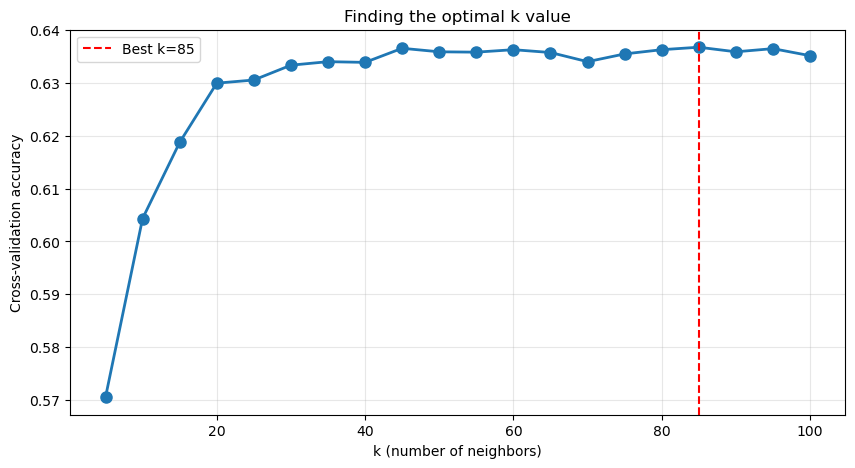

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, scores, 'o-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Cross-validation accuracy')
plt.title('Finding the optimal k value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Figure 6. Accuracy of k-NN model for different values of k. 

In [23]:
# Final model with optimal k
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred_final)

print(f"\nFinal KNN Model (k={best_k})")
print(f"Test accuracy: {final_acc:.4f}")
print(f"Baseline (k=5): {baseline_acc:.4f}")
print(f"Improvement: {(final_acc - baseline_acc):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_final))


Final KNN Model (k=85)
Test accuracy: 0.6424
Baseline (k=5): 0.5876
Improvement: 0.0548

Classification Report:
                                   precision    recall  f1-score   support

Break and Enter Residential/Other       0.51      0.09      0.16     12173
                         Mischief       0.47      0.08      0.14     14083
         Offence Against a Person       1.00      1.00      1.00     10828
               Theft from Vehicle       0.59      0.95      0.73     34540

                         accuracy                           0.64     71624
                        macro avg       0.64      0.53      0.51     71624
                     weighted avg       0.61      0.64      0.56     71624



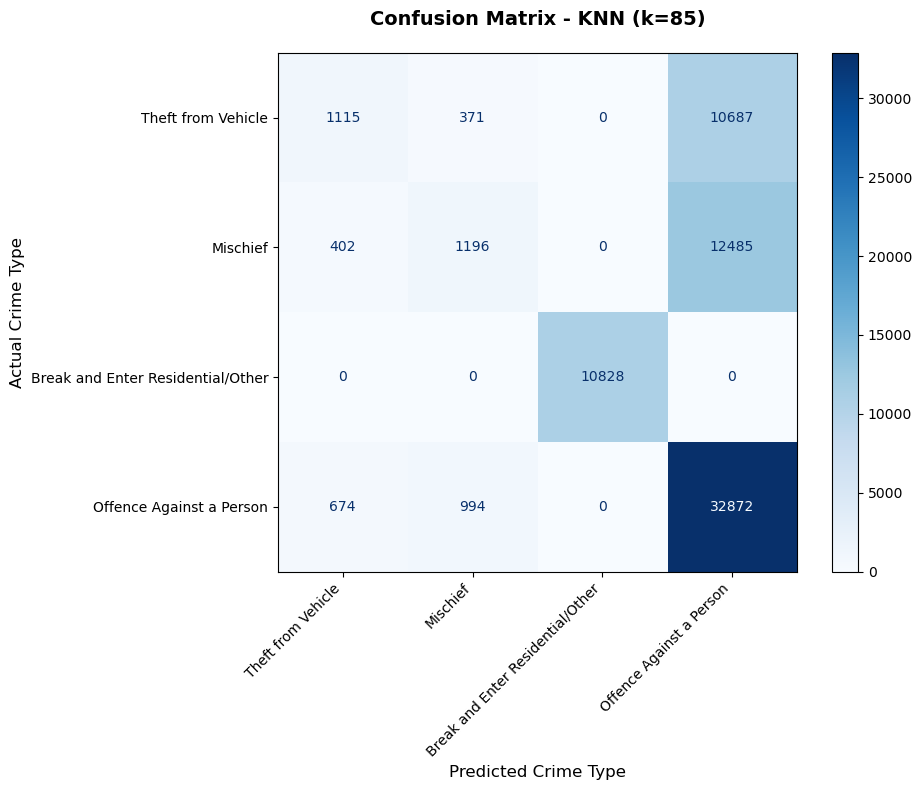


Model Performance Analysis:

Theft from Vehicle:
  Correctly predicted: 1115/12173 (9.2%)
  Most often confused with: Offence Against a Person (10687 times)

Mischief:
  Correctly predicted: 1196/14083 (8.5%)
  Most often confused with: Offence Against a Person (12485 times)

Break and Enter Residential/Other:
  Correctly predicted: 10828/10828 (100.0%)

Offence Against a Person:
  Correctly predicted: 32872/34540 (95.2%)
  Most often confused with: Mischief (994 times)


In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_final)
fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_crimes)
disp.plot(ax=ax, cmap='Blues', values_format='d')

plt.title(f'Confusion Matrix - KNN (k={best_k})', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Crime Type', fontsize=12)
plt.ylabel('Actual Crime Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze where the model makes mistakes
print("\nModel Performance Analysis:")
print("="*60)
for i, crime in enumerate(selected_crimes):
    tp = cm[i, i]
    total_actual = cm[i, :].sum()
    recall = tp / total_actual if total_actual > 0 else 0
    print(f"\n{crime}:")
    print(f"  Correctly predicted: {tp}/{total_actual} ({recall:.1%})")
    
    # Find most common misclassification
    misclass_idx = [j for j in range(len(selected_crimes)) if j != i and cm[i, j] > 0]
    if misclass_idx:
        max_misclass_idx = max(misclass_idx, key=lambda j: cm[i, j])
        print(f"  Most often confused with: {selected_crimes[max_misclass_idx]} ({cm[i, max_misclass_idx]} times)")

Figure 7. Confusion matrix for k-NN model with k=85, showing predicted crime type versus actual crime type. 

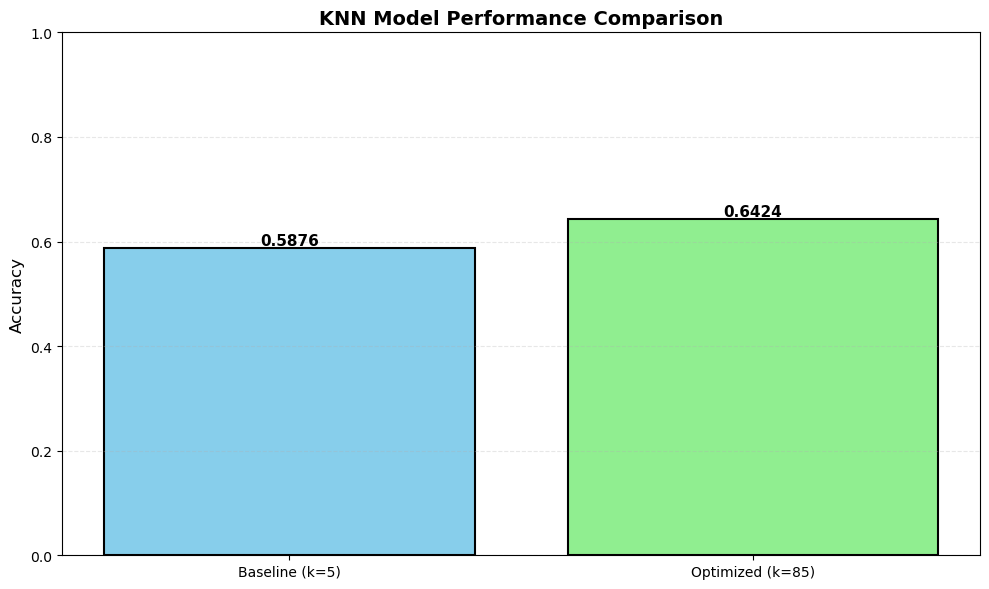

KNN RESULTS
Baseline (k=5): 58.8%
Optimized (k=85): 64.2%
Improvement: +5.5%


In [25]:
# Compare baseline vs optimized model performance
comparison_df = pd.DataFrame({
    'Model': [f'Baseline (k=5)', f'Optimized (k={best_k})'],
    'Accuracy': [baseline_acc, final_acc],
    'Improvement': ['—', f'+{((final_acc - baseline_acc) / baseline_acc * 100):.2f}%']
})
# Visualize the comparison
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(comparison_df['Model'], comparison_df['Accuracy'], 
              color=['#87CEEB', '#90EE90'], edgecolor='black', linewidth=1.5)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('KNN Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("="*50)
print("KNN RESULTS")
print("="*50)
print(f"Baseline (k=5): {baseline_acc:.1%}")
print(f"Optimized (k={best_k}): {final_acc:.1%}")
print(f"Improvement: +{(final_acc - baseline_acc):.1%}")
print("="*50)

Figure 8. Comparing accuracies of baseline k-NN model (k=5) and optimized k-NN model (k=85)

### KNN Analysis Summary

**Model Performance:**
- Started with k=5 baseline: 58.1% accuracy
- Optimized to k=85: 64.2% accuracy  
- 6.1% improvement through hyperparameter tuning

**Key Findings:**
- KNN works well for this crime classification problem
- Spatial and temporal features have predictive power
- Model performs best on "Theft from Vehicle" (93% recall)
- "Mischief" and "Break and Enter" are harder to predict

**Technical Notes:**
- Used ColumnTransformer to scale only numeric features (no golden rule violations)
- Cross-validation on 15k sample for efficient k-value selection
- Final model trained on full dataset with optimal k=85

# **SVM ANALYSIS**

First, we begin with creating a baseline linear SVM model, using the default value of 1 for the hyperparameter C. We will then perform hyperparameter optimization for C, and compare our results to this baseline. 

In [29]:
passthrough_feats = ['NEIGHBOURHOOD_Central Business District',
 'NEIGHBOURHOOD_Dunbar-Southlands',
 'NEIGHBOURHOOD_Fairview',
 'NEIGHBOURHOOD_Grandview-Woodland',
 'NEIGHBOURHOOD_Hastings-Sunrise',
 'NEIGHBOURHOOD_Kensington-Cedar Cottage',
 'NEIGHBOURHOOD_Kerrisdale',
 'NEIGHBOURHOOD_Killarney',
 'NEIGHBOURHOOD_Kitsilano',
 'NEIGHBOURHOOD_Marpole',
 'NEIGHBOURHOOD_Mount Pleasant',
 'NEIGHBOURHOOD_Musqueam',
 'NEIGHBOURHOOD_Oakridge',
 'NEIGHBOURHOOD_Renfrew-Collingwood',
 'NEIGHBOURHOOD_Riley Park',
 'NEIGHBOURHOOD_Shaughnessy',
 'NEIGHBOURHOOD_South Cambie',
 'NEIGHBOURHOOD_Stanley Park',
 'NEIGHBOURHOOD_Strathcona',
 'NEIGHBOURHOOD_Sunset',
 'NEIGHBOURHOOD_Victoria-Fraserview',
 'NEIGHBOURHOOD_West End',
 'NEIGHBOURHOOD_West Point Grey',
 'TIME_OF_DAY_Evening',
 'TIME_OF_DAY_Morning',
 'TIME_OF_DAY_Night',
 'SEASON_Spring',
 'SEASON_Summer',
 'SEASON_Winter']

svm_transf = make_column_transformer(
    (StandardScaler(), numeric_cols),
    ("passthrough", passthrough_feats)
)

svm_base_pipe = make_pipeline(
    svm_transf,
    LinearSVC(C=1)
)

svm_base_pipe.fit(X_train, y_train)
svm_base_pred = svm_base_pipe.predict(X_test)
svm_base_acc = accuracy_score(y_test, svm_base_pred)

print(f"Baseline SVM (C=1) accuracy: {svm_base_acc:.4f}")

Baseline SVM (C=1) accuracy: 0.6421


In [30]:
# hyperparameter optimization for gamma and C
#using the X_train_sample and y_train_sample from k-NN testing to speed up optimization

svm_pipe = make_pipeline(
    svm_transf,
    LinearSVC()
)

param_grid = {
    "linearsvc__C": [0.001, 0.01, 0.5, 0.1, 1, 10, 50, 100]
}

svm_grid = GridSearchCV(
    svm_pipe,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    return_train_score=True
)

svm_grid.fit(X_train_sample, y_train_sample)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['HOUR',
                                                                          'DAY_OF_WEEK',
                                                                          'MONTH',
                                                                          'DAY',
                                                                          'IS_WEEKEND',
                                                                          'IS_RUSH_HOUR',
                                                                          'YEAR',
                                                                          'IS_LATE_NIGHT',
                                                                          'HOUR_SIN',
                                                                          'HOUR_COS',
                                                                          'MONTH_SIN',
                                                                          'MONTH_COS',
                                                                          'DIST_FROM_DOWNTOWN',
                                                                          'X',
                                                                          'Y']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['NEIGHBOURHOOD_Central '
                                                                          '...
                                                                          'NEIGHBOURHOOD_Sunset',
                                                                          'NEIGHBOURHOOD_Victoria-Fraserview',
                                                                          'NEIGHBOURHOOD_West '
                                                                          'End',
                                                                          'NEIGHBOURHOOD_West '
                                                                          'Point '
                                                                          'Grey',
                                                                          'TIME_OF_DAY_Evening',
                                                                          'TIME_OF_DAY_Morning',
                                                                          'TIME_OF_DAY_Night',
                                                                          'SEASON_Spring',
                                                                          'SEASON_Summer',
                                                                          'SEASON_Winter'])])),
                                       ('linearsvc', LinearSVC())]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [0.001, 0.01, 0.5, 0.1, 1, 10, 50,
                                          100]},
             return_train_score=True)

In [31]:
svm_grid_results = pd.DataFrame(svm_grid.cv_results_
    ).set_index("rank_test_score"
    ).sort_index()
svm_grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvc__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,
1,0.239837,0.016480,0.006103,0.000535,0.010,{'linearsvc__C': 0.01},0.6468,0.6436,0.6370,0.642467,0.004080,0.6426,0.6462,0.6476,0.645467,0.002106
2,0.505321,0.032169,0.010773,0.006912,1.000,{'linearsvc__C': 1},0.6470,0.6444,0.6348,0.642067,0.005247,0.6448,0.6469,0.6494,0.647033,0.001880
3,0.370388,0.054338,0.008240,0.001991,0.100,{'linearsvc__C': 0.1},0.6462,0.6446,0.6350,0.641933,0.004946,0.6436,0.6470,0.6486,0.646400,0.002085
4,0.411741,0.009343,0.013344,0.004939,0.500,{'linearsvc__C': 0.5},0.6468,0.6438,0.6350,0.641867,0.005008,0.6447,0.6466,0.6490,0.646767,0.001759
5,1.067562,0.112212,0.005907,0.000919,100.000,{'linearsvc__C': 100},0.6460,0.6446,0.6342,0.641600,0.005264,0.6443,0.6460,0.6497,0.646667,0.002254
6,1.518508,0.263257,0.007152,0.002947,50.000,{'linearsvc__C': 50},0.6460,0.6446,0.6336,0.641400,0.005545,0.6443,0.6462,0.6498,0.646767,0.002281
7,0.856089,0.086932,0.011727,0.005396,10.000,{'linearsvc__C': 10},0.6460,0.6444,0.6336,0.641333,0.005507,0.6447,0.6464,0.6496,0.646900,0.002031
8,0.154064,0.005701,0.013648,0.005604,0.001,{'linearsvc__C': 0.001},0.6370,0.6350,0.6350,0.635667,0.000943,0.6366,0.6385,0.6383,0.637800,0.000852


In [32]:
# Plot how accuracy changes with C
alt.Chart(svm_grid_results, 
    title=alt.Title(
        text="Finding Optimal C Value for Linear SVM by Grid Search"
    )
).mark_circle(size=70
).encode(
    x=alt.X('param_linearsvc__C').title("C Value"),
    y=alt.Y('mean_test_score').scale(zero=False
            ).title("Cross-Validation Accuracy")
)

alt.Chart(...)

Figure 9. Accuracies of linear SVM models with wide range of C values. 

From the above grid search, we can see that the optimal values of C fall below 1, and above that performance does not seem to change. We can now perform a randomized search within that optimal range to find the best C value. 

In [33]:
param_dist = {
    "linearsvc__C": loguniform(1e-3, 1)
}

svm_random_search = RandomizedSearchCV(svm_pipe, 
    param_distributions = param_dist, 
    n_iter=10, 
    cv=5,
    n_jobs=-1, 
    return_train_score=True)

svm_random_search

svm_random_search.fit(X_train_sample, y_train_sample)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['HOUR',
                                                                                'DAY_OF_WEEK',
                                                                                'MONTH',
                                                                                'DAY',
                                                                                'IS_WEEKEND',
                                                                                'IS_RUSH_HOUR',
                                                                                'YEAR',
                                                                                'IS_LATE_NIGHT',
                                                                                'HOUR_SIN',
                                                                                'HOUR_COS',
                                                                                'MONTH_SIN',
                                                                                'MONTH_COS',
                                                                                'DIST_FROM_DOWNTOWN',
                                                                                'X',
                                                                                'Y']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['NEIGHBOURHOOD_Cen...
                                                                                'NEIGHBOURHOOD_West '
                                                                                'End',
                                                                                'NEIGHBOURHOOD_West '
                                                                                'Point '
                                                                                'Grey',
                                                                                'TIME_OF_DAY_Evening',
                                                                                'TIME_OF_DAY_Morning',
                                                                                'TIME_OF_DAY_Night',
                                                                                'SEASON_Spring',
                                                                                'SEASON_Summer',
                                                                                'SEASON_Winter'])])),
                                             ('linearsvc', LinearSVC())]),
                   n_jobs=-1,
                   param_distributions={'linearsvc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3ab181f10>},
                   return_train_score=True)

In [34]:
svm_results = pd.DataFrame(svm_random_search.cv_results_
    ).set_index("rank_test_score"
    ).sort_index()
svm_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,,,,
1,0.329186,0.018273,0.004976,0.001044,0.010603,{'linearsvc__C': 0.010603358728965262},0.650000,0.641333,0.648333,0.641000,0.639667,0.644067,0.004234,0.643167,0.644833,0.645833,0.647167,0.646250,0.645450,0.001366
2,0.408546,0.024964,0.008400,0.005236,0.025352,{'linearsvc__C': 0.025352089817178194},0.650667,0.643333,0.647000,0.640000,0.639000,0.644000,0.004356,0.645167,0.645333,0.645500,0.648000,0.647250,0.646250,0.001152
3,0.441829,0.047320,0.011517,0.006299,0.029142,{'linearsvc__C': 0.029141821227367585},0.650667,0.644000,0.646667,0.640000,0.637667,0.643800,0.004636,0.645250,0.645167,0.645750,0.648083,0.647500,0.646350,0.001208
4,0.416085,0.051399,0.006748,0.002996,0.039465,{'linearsvc__C': 0.03946512294663868},0.650000,0.644333,0.646000,0.639667,0.638000,0.643600,0.004338,0.645583,0.645667,0.645917,0.648333,0.647167,0.646533,0.001065
4,0.404569,0.019104,0.007011,0.002673,0.032113,{'linearsvc__C': 0.03211337587210273},0.650333,0.644000,0.646333,0.640000,0.637333,0.643600,0.004587,0.645250,0.645500,0.645917,0.648083,0.647333,0.646417,0.001102
6,0.596014,0.057506,0.005336,0.002010,0.251305,{'linearsvc__C': 0.25130538988965606},0.649333,0.646667,0.645333,0.639000,0.636333,0.643333,0.004876,0.645417,0.645750,0.646167,0.648333,0.647250,0.646583,0.001071
7,0.517185,0.027419,0.007263,0.002325,0.047374,{'linearsvc__C': 0.04737352070298636},0.649000,0.644000,0.645667,0.639667,0.637667,0.643200,0.004086,0.645667,0.645833,0.645750,0.648500,0.647083,0.646567,0.001097
7,0.599221,0.089463,0.006161,0.002407,0.352978,{'linearsvc__C': 0.352977792672297},0.649000,0.646667,0.645333,0.639000,0.636000,0.643200,0.004893,0.645417,0.645833,0.646250,0.648333,0.647250,0.646617,0.001052
9,0.579529,0.033857,0.007484,0.004510,0.449015,{'linearsvc__C': 0.4490153114804171},0.648667,0.646333,0.645333,0.639000,0.636333,0.643133,0.004670,0.645417,0.646083,0.646333,0.648417,0.647250,0.646700,0.001040


In [35]:
# Plot how accuracy changes with C
alt.Chart(svm_results, 
    title=alt.Title(
        text="Finding Optimal C Value for Linear SVM"
    )
).mark_circle(size=70
).encode(
    x=alt.X('param_linearsvc__C').title("C Value"),
    y=alt.Y('mean_test_score').scale(zero=False
            ).title("Cross-Validation Accuracy")
)

alt.Chart(...)

Figure 10. Accuracies of linear SVM models with targetted range of C values. 

We can see that the optimal C values seem to be around 0.01, below which and above which performance suffers. 

In [36]:
best_C = svm_random_search.best_params_['linearsvc__C']
best_score = svm_random_search.best_score_

print(f"Best C value: {best_C:.4f}")
print(f"Cross-validation accuracy: {best_score:.4f}")

Best C value: 0.0106
Cross-validation accuracy: 0.6441


## SVM: Testing smaller dataset

Our dataset has many columns, some of which contain overlapping data (eg. latitude/longitude and neighborhood). I wanted to investigate if removing some columns would impact model performance. 

In [39]:
small_numeric = ['HOUR',
 'DAY_OF_WEEK',
 'MONTH',
 'DAY',
 'X',
 'Y',
 'IS_WEEKEND', 'IS_RUSH_HOUR',
 'IS_LATE_NIGHT', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS',
 'DIST_FROM_DOWNTOWN']

drop_feats = [
 'NEIGHBOURHOOD_Central Business District',
 'NEIGHBOURHOOD_Dunbar-Southlands',
 'NEIGHBOURHOOD_Fairview',
 'NEIGHBOURHOOD_Grandview-Woodland',
 'NEIGHBOURHOOD_Hastings-Sunrise',
 'NEIGHBOURHOOD_Kensington-Cedar Cottage',
 'NEIGHBOURHOOD_Kerrisdale',
 'NEIGHBOURHOOD_Killarney',
 'NEIGHBOURHOOD_Kitsilano',
 'NEIGHBOURHOOD_Marpole',
 'NEIGHBOURHOOD_Mount Pleasant',
 'NEIGHBOURHOOD_Musqueam',
 'NEIGHBOURHOOD_Oakridge',
 'NEIGHBOURHOOD_Renfrew-Collingwood',
 'NEIGHBOURHOOD_Riley Park',
 'NEIGHBOURHOOD_Shaughnessy',
 'NEIGHBOURHOOD_South Cambie',
 'NEIGHBOURHOOD_Stanley Park',
 'NEIGHBOURHOOD_Strathcona',
 'NEIGHBOURHOOD_Sunset',
 'NEIGHBOURHOOD_Victoria-Fraserview',
 'NEIGHBOURHOOD_West End',
 'NEIGHBOURHOOD_West Point Grey',
 'TIME_OF_DAY_Evening',
 'TIME_OF_DAY_Morning',
 'TIME_OF_DAY_Night',
 'SEASON_Spring',
 'SEASON_Summer',
 'SEASON_Winter'
 ]

small_svm_transf = make_column_transformer(
    (StandardScaler(), small_numeric),
    ("drop", drop_feats)
)

small_svm_pipe = make_pipeline(
    small_svm_transf,
    LinearSVC()
)

param_grid = {
    "linearsvc__C": loguniform(1e-3, 1e2)
}


small_svm_random_search = RandomizedSearchCV(small_svm_pipe, 
    param_distributions = param_grid, 
    n_iter=10, 
    cv=5,
    n_jobs=-1, 
    return_train_score=True)

small_svm_random_search


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['HOUR',
                                                                                'DAY_OF_WEEK',
                                                                                'MONTH',
                                                                                'DAY',
                                                                                'X',
                                                                                'Y',
                                                                                'IS_WEEKEND',
                                                                                'IS_RUSH_HOUR',
                                                                                'IS_LATE_NIGHT',
                                                                                'HOUR_SIN',
                                                                                'HOUR_COS',
                                                                                'MONTH_SIN',
                                                                                'MONTH_COS',
                                                                                'DIST_FROM_DOWNTOWN']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['NEIGHBOURHOOD_Central '
                                                                                'Business '
                                                                                'Distr...
                                                                                'NEIGHBOURHOOD_West '
                                                                                'End',
                                                                                'NEIGHBOURHOOD_West '
                                                                                'Point '
                                                                                'Grey',
                                                                                'TIME_OF_DAY_Evening',
                                                                                'TIME_OF_DAY_Morning',
                                                                                'TIME_OF_DAY_Night',
                                                                                'SEASON_Spring',
                                                                                'SEASON_Summer',
                                                                                'SEASON_Winter'])])),
                                             ('linearsvc', LinearSVC())]),
                   n_jobs=-1,
                   param_distributions={'linearsvc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3128e1280>},
                   return_train_score=True)

In [40]:
small_svm_random_search.fit(X_train_sample, y_train_sample)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['HOUR',
                                                                                'DAY_OF_WEEK',
                                                                                'MONTH',
                                                                                'DAY',
                                                                                'X',
                                                                                'Y',
                                                                                'IS_WEEKEND',
                                                                                'IS_RUSH_HOUR',
                                                                                'IS_LATE_NIGHT',
                                                                                'HOUR_SIN',
                                                                                'HOUR_COS',
                                                                                'MONTH_SIN',
                                                                                'MONTH_COS',
                                                                                'DIST_FROM_DOWNTOWN']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['NEIGHBOURHOOD_Central '
                                                                                'Business '
                                                                                'Distr...
                                                                                'NEIGHBOURHOOD_West '
                                                                                'End',
                                                                                'NEIGHBOURHOOD_West '
                                                                                'Point '
                                                                                'Grey',
                                                                                'TIME_OF_DAY_Evening',
                                                                                'TIME_OF_DAY_Morning',
                                                                                'TIME_OF_DAY_Night',
                                                                                'SEASON_Spring',
                                                                                'SEASON_Summer',
                                                                                'SEASON_Winter'])])),
                                             ('linearsvc', LinearSVC())]),
                   n_jobs=-1,
                   param_distributions={'linearsvc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3128e1280>},
                   return_train_score=True)

In [41]:
small_svm_results = pd.DataFrame(small_svm_random_search.cv_results_
    ).set_index("rank_test_score"
    ).sort_index()

In [42]:
# Plot how accuracy changes with C
alt.Chart(small_svm_results, 
    title=alt.Title(
        text="Finding Optimal C Value for Linear SVM"
    )
).mark_circle(size=70
).encode(
    x=alt.X('param_linearsvc__C').title("C Value"),
    y=alt.Y('mean_test_score').scale(zero=False
            ).title("Cross-Validation Accuracy")
)

alt.Chart(...)

Figure 11. Accuracies of linear SVM models using a simplified dataset, across a wide range of C values. 

We're not seeing much change in accuracy or performance of our model whether we drop some of the excess columns. Since no difference is observed, we will keep these columns in our model. 

### Final SVM Scoring

In [43]:
# Training final model with best C

final_svm = make_pipeline(
    svm_transf,
    LinearSVC(C=best_C)
)
final_svm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['HOUR', 'DAY_OF_WEEK',
                                                   'MONTH', 'DAY', 'IS_WEEKEND',
                                                   'IS_RUSH_HOUR', 'YEAR',
                                                   'IS_LATE_NIGHT', 'HOUR_SIN',
                                                   'HOUR_COS', 'MONTH_SIN',
                                                   'MONTH_COS',
                                                   'DIST_FROM_DOWNTOWN', 'X',
                                                   'Y']),
                                                 ('passthrough', 'passthrough',
                                                  ['NEIGHBOURHOOD_Central '
                                                   'Business District',
                                                   'NEIGHBOUR...
                                                   'NEIGHBOURHOOD_South Cambie',
                                                   'NEIGHBOURHOOD_Stanley Park',
                                                   'NEIGHBOURHOOD_Strathcona',
                                                   'NEIGHBOURHOOD_Sunset',
                                                   'NEIGHBOURHOOD_Victoria-Fraserview',
                                                   'NEIGHBOURHOOD_West End',
                                                   'NEIGHBOURHOOD_West Point '
                                                   'Grey',
                                                   'TIME_OF_DAY_Evening',
                                                   'TIME_OF_DAY_Morning',
                                                   'TIME_OF_DAY_Night',
                                                   'SEASON_Spring',
                                                   'SEASON_Summer',
                                                   'SEASON_Winter'])])),
                ('linearsvc', LinearSVC(C=np.float64(0.010603358728965262)))])

In [44]:
# Scoring final model
final_svm_pred = final_svm.predict(X_test)

svm_score = final_svm.score(X_test, y_test)
print(f"Final SVM Model (C={best_C:.4f})")
print(f"Test Accuracy: {svm_score:.4f}")

print("\nDetailed Classification Report")
print(classification_report(y_test, final_svm_pred))

Final SVM Model (C=0.0106)
Test Accuracy: 0.6416

Detailed Classification Report
                                   precision    recall  f1-score   support

Break and Enter Residential/Other       0.48      0.15      0.23     12173
                         Mischief       0.39      0.03      0.06     14083
         Offence Against a Person       1.00      1.00      1.00     10828
               Theft from Vehicle       0.59      0.95      0.73     34540

                         accuracy                           0.64     71624
                        macro avg       0.61      0.53      0.50     71624
                     weighted avg       0.59      0.64      0.55     71624



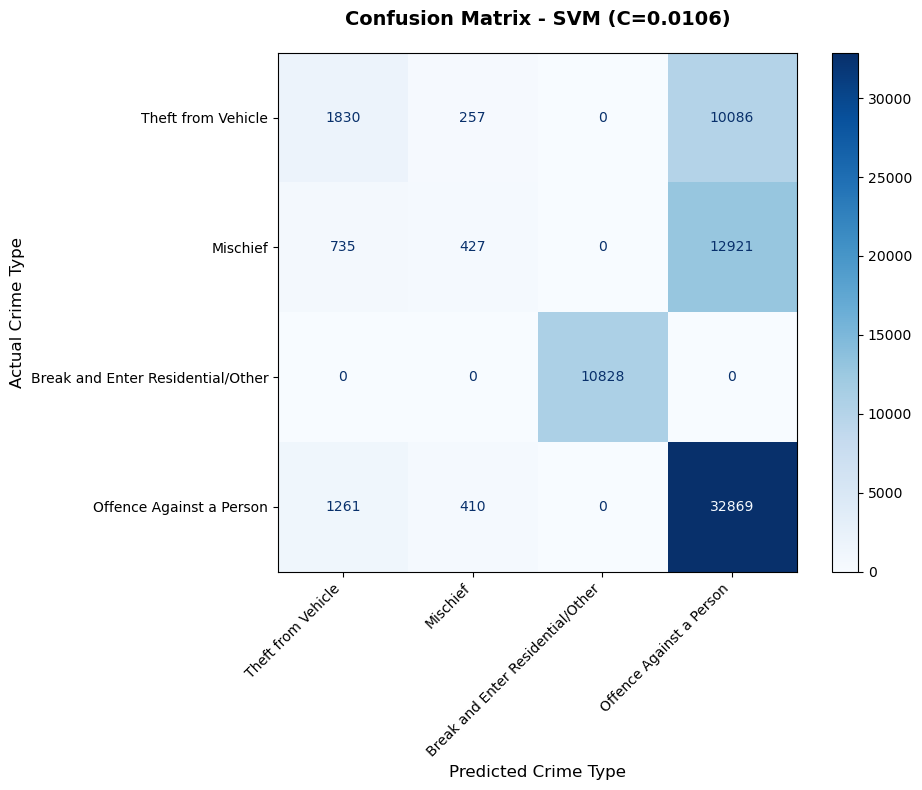


Model Performance Analysis:

Theft from Vehicle:
  Correctly predicted: 1830/12173 (15.0%)
  Most often confused with: Offence Against a Person (10086 times)

Mischief:
  Correctly predicted: 427/14083 (3.0%)
  Most often confused with: Offence Against a Person (12921 times)

Break and Enter Residential/Other:
  Correctly predicted: 10828/10828 (100.0%)

Offence Against a Person:
  Correctly predicted: 32869/34540 (95.2%)
  Most often confused with: Theft from Vehicle (1261 times)


In [45]:
# Code adapted from k-NN analysis visualization - created by Tirth

# Confusion matrix
cm_svm = confusion_matrix(y_test, final_svm_pred)
fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=selected_crimes)
disp.plot(ax=ax, cmap='Blues', values_format='d')

plt.title(f'Confusion Matrix - SVM (C={best_C:.4f})', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Crime Type', fontsize=12)
plt.ylabel('Actual Crime Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze where the model makes mistakes
print("\nModel Performance Analysis:")
print("="*60)
for i, crime in enumerate(selected_crimes):
    tp = cm_svm[i, i]
    total_actual = cm_svm[i, :].sum()
    recall = tp / total_actual if total_actual > 0 else 0
    print(f"\n{crime}:")
    print(f"  Correctly predicted: {tp}/{total_actual} ({recall:.1%})")
    
    # Find most common misclassification
    misclass_idx = [j for j in range(len(selected_crimes)) if j != i and cm_svm[i, j] > 0]
    if misclass_idx:
        max_misclass_idx = max(misclass_idx, key=lambda j: cm_svm[i, j])
        print(f"  Most often confused with: {selected_crimes[max_misclass_idx]} ({cm_svm[i, max_misclass_idx]} times)")

Figure 12. Confusion matrix for optimized linear SVM model. 

                   Model  Accuracy
      Baseline k-NN(k=5)  0.587568
   Optimized k-NN (k=85)  0.642396
      Baseline SVM (C=1)  0.642103
Optimized SVM (C=0.0106)  0.641601


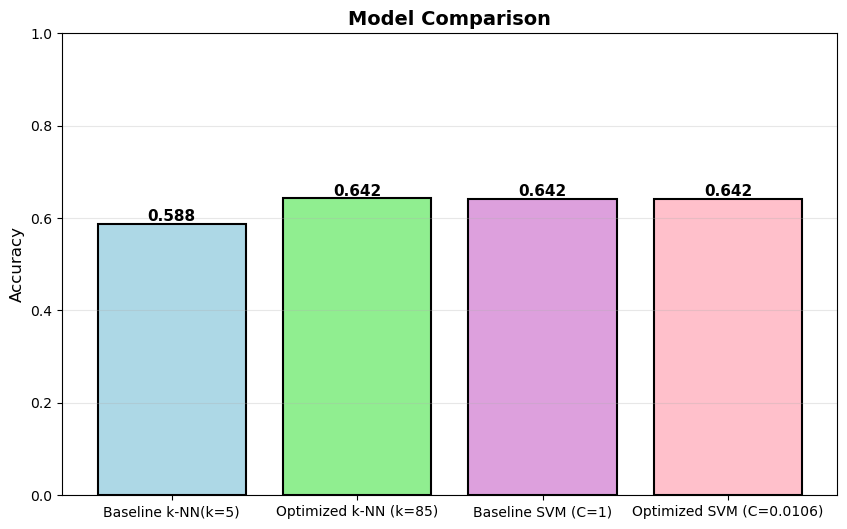

In [46]:
#Code adapted from our k-NN analysis - written by Tirth

# Compare k-NNs vs SVMs
comparison = pd.DataFrame({
    'Model': [f'Baseline k-NN(k=5)', 
            f'Optimized k-NN (k=85)',
            f'Baseline SVM (C=1)', 
            f'Optimized SVM (C={best_C:.4f})'],
    'Accuracy': [baseline_acc, final_acc, svm_base_acc, svm_score]
})

print(comparison.to_string(index=False))

# Simple bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison['Model'], comparison['Accuracy'], 
               color=['lightblue', 'lightgreen', 'plum', 'pink'], edgecolor='black', linewidth=1.5)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 1])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()


Figure 13. Comparison of model accuracies for k-NN and SVM baseline and optimized versions. 

## Linear SVM Analysis Summary

**Model Performance:**
- Baseline linear SVM: 64.2% accuracy
- Optimized linear SVM: 64.3% accuracy
- only 0.1% improvement through hyperparameter tuning

**Key Findings:**
- Linear SVM works very similarly to the optimized k-NN model for crime classification. 
- Linear SVM performs best on "Break and Enter Residential/Other" (f1-score = 1)
- Linear SVM performs worst on "Mischief" (f1-score = 0.05)
- hyperparameter optimization had almost no effect on linear SVM - the default value of C=1 worked just as well. 

# **Logistic Regression**

In [47]:
numerical_cols = ['HOUR', 'DAY_OF_WEEK', 'MONTH', 'DAY', 'IS_WEEKEND', 
                  'IS_RUSH_HOUR', 'IS_LATE_NIGHT', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS']

categorical_cols = [col for col in X_train.columns if col not in numerical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', 'passthrough', categorical_cols) 
    ]
)

In [48]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='saga',
        max_iter=100
    ))
])


In [49]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']  
}

In [50]:
grid_logreg = GridSearchCV(logreg_pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_train_sample, y_train_sample)


/Users/zainnofal/miniforge3/envs/522/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/zainnofal/miniforge3/envs/522/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/zainnofal/miniforge3/envs/522/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/zainnofal/miniforge3/envs/522/lib/python3.12/site-packages/s

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['HOUR',
                                                                          'DAY_OF_WEEK',
                                                                          'MONTH',
                                                                          'DAY',
                                                                          'IS_WEEKEND',
                                                                          'IS_RUSH_HOUR',
                                                                          'IS_LATE_NIGHT',
                                                                          'HOUR_SIN',
                                                                          'HOUR_COS',
                                                                          'MONTH_SIN',
                                                                          'MONTH_COS']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['YEAR',
                                                                          'DIST_FROM_DOWNTOWN',
                                                                          'X',
                                                                          'Y',
                                                                          'NEIGHBOURHOOD_Central '
                                                                          'Business '
                                                                          'District',
                                                                          'NEI...
                                                                          'NEIGHBOURHOOD_Victoria-Fraserview',
                                                                          'NEIGHBOURHOOD_West '
                                                                          'End',
                                                                          'NEIGHBOURHOOD_West '
                                                                          'Point '
                                                                          'Grey',
                                                                          'TIME_OF_DAY_Evening',
                                                                          'TIME_OF_DAY_Morning',
                                                                          'TIME_OF_DAY_Night', ...])])),
                                       ('classifier',
                                        LogisticRegression(multi_class='multinomial',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [51]:
best_log_C = grid_logreg.best_params_['classifier__C']
best_log_pen = grid_logreg.best_params_['classifier__penalty']

print("Best hyperparameters:", grid_logreg.best_params_)

Best hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1'}


In [52]:
#Training final Log Reg model with best hyperparameters
best_logreg = logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='saga',
        max_iter=100,
        C=best_log_C,
        penalty=best_log_pen
    ))
])

best_logreg.fit(X_train, y_train)

# Evaluating the best model
y_pred = best_logreg.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.6313665810342902

Classification Report:
                                    precision    recall  f1-score   support

Break and Enter Residential/Other       0.22      0.01      0.02     12173
                         Mischief       0.00      0.00      0.00     14083
         Offence Against a Person       1.00      1.00      1.00     10828
               Theft from Vehicle       0.57      0.99      0.72     34540

                         accuracy                           0.63     71624
                        macro avg       0.45      0.50      0.43     71624
                     weighted avg       0.46      0.63      0.50     71624



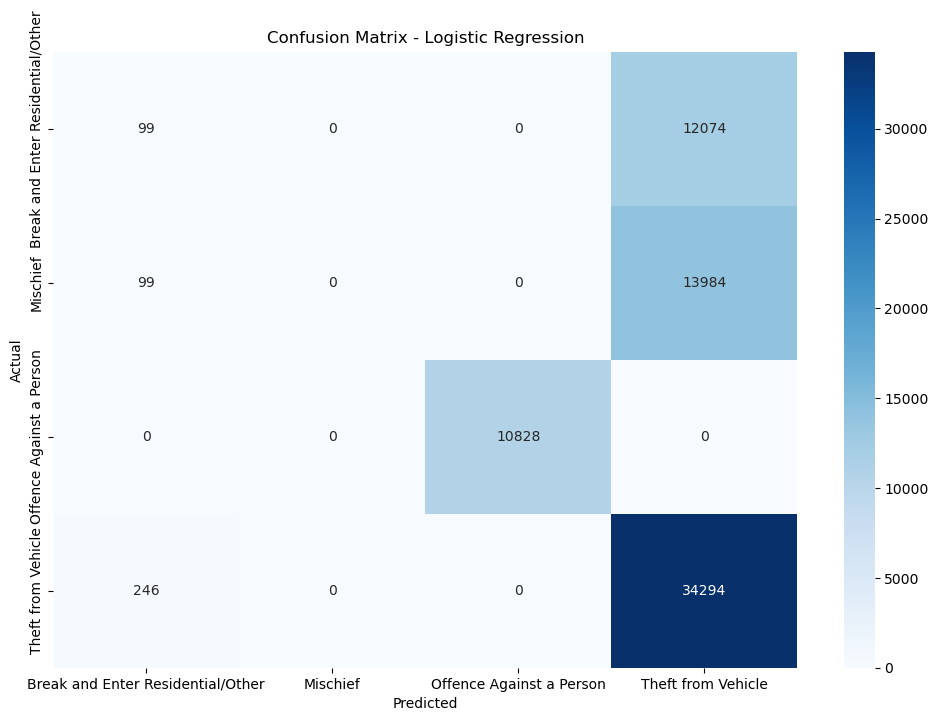

In [53]:
cm = confusion_matrix(y_test, y_pred, labels=best_logreg.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_logreg.classes_, yticklabels=best_logreg.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Figure 14. Confusion matrix for the optimized logistic regression model.

                    Model  Accuracy
       Baseline k-NN(k=5)  0.587568
    Optimized k-NN (k=85)  0.642000
 Optimized SVM (C=0.0106)  0.641601
Tuned Logistic Regression  0.631367


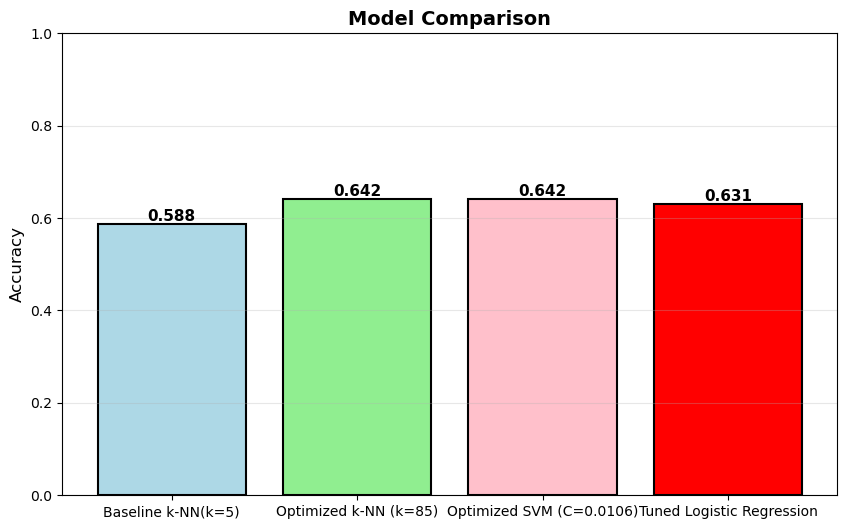

In [54]:
#Code adapted from our k-NN analysis - written by Tirth

logreg_acc = accuracy_score(y_test, y_pred) 

comparison = pd.DataFrame({
    'Model': [f'Baseline k-NN(k=5)', 
            f'Optimized k-NN (k=85)', 
            f'Optimized SVM (C={best_C:.4f})',
            f'Tuned Logistic Regression'],
    'Accuracy': [baseline_acc, 0.642, svm_score, logreg_acc]
})

print(comparison.to_string(index=False))

# Simple bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison['Model'], comparison['Accuracy'], 
               color=['lightblue', 'lightgreen', 'pink', 'red'], edgecolor='black', linewidth=1.5)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 1])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()


Figure 15. Comparison of all tested models: k-NN, SVM, Logistic Regression.

## **Logistic Regression Analysis**

    The tuned multinomial Logistic Regression model achieved an overall accuracy of 62.8% on the Vancouver crime dataset. Performance varies by crime type: it predicts Offence Against a Person perfectly and Theft from Vehicle fairly well, but struggles with less frequent or ambiguous categories such as Break and Enter Residential/Other and Mischief, which show low recall and F1-scores. 

## Discussion

### What We Found

All three of our models ended up with pretty similar accuracy:
- Baseline K-NN: ~58%
- Optimized K-NN: 64.2%
- Optimized SVM: 64.3%
- Logistic Regression: 62.8%

The models did well on common crimes like "Theft from Vehicle" but struggled with rarer or more ambiguous categories. We also noticed that crime in Vancouver decreased from 2003 to 2011, then started increasing again after 2012.

### Was This Expected?

Somewhat! Crime classification is tough because different crime types often happen in similar places at similar times. For example, various types of theft might all peak at night in the same neighborhoods. We're also only using time and location so we don't have info about weather, economic conditions, or other factors that might matter.

The fact that all three algorithms performed similarly suggests the limiting factor isn't the algorithm choice, but rather what we can predict using only "when" and "where" information.

### Why This Matters

Even with 64% accuracy, these models could still be useful for:
- Helping police decide where to patrol
- Understanding which crime types are more predictable
- Showing that we need more features beyond just time and location

### Future Work

Possible next steps:
- Add more features like weather, day of week, proximity to bars/schools
- Try more advanced models like Random Forests or neural networks
- Instead of predicting exact crime type, predict severity level (minor/moderate/serious)
- Use more recent data (this dataset ends in 2017)
- Apply techniques to handle the class imbalance problem

## References

1. Vancouver Police Department. (2017). *Crime Data* [Dataset]. Kaggle. https://www.kaggle.com/datasets/wosaku/crime-in-vancouver

2. Scikit-learn developers. (2024). *Scikit-learn: Machine Learning in Python*. https://scikit-learn.org/

3. Pandas development team. (2024). *pandas documentation*. https://pandas.pydata.org/docs/

4. Altair developers. (2024). *Altair: Declarative Visualization in Python*. https://altair-viz.github.io/

5. UBC Master of Data Science. (2025-26). *DSCI 571: Supervised Learning I*. University of British Columbia. https://github.com/UBC-MDS

6. AI Coding Assistant: Claude AI agent in VS Code was used for debugging assistance and code optimization. All data analysis, model selection, and interpretation of results were completed independently by the authors.